# AIP 4 - Project Rechin
## Strategic Thinking - CA4 - Sprint 2
## Project Rechin - Can an AI Beat a Human Trader

## Import Libraries for Back Testing and Visualization

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle
import mysql.connector 
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

from backtesting import Backtest
from backtesting import Strategy
#from backtesting import Trade
from backtesting.lib import crossover


Loading BokehJS ...

## Credintials for AWS

In [2]:
# Credentials to database connection
hostname="database-rechin.123456.eu-west-1.rds.amazonaws.com" #Antonio's AWS
uname="admin"
pwd="rechin"
dbName = 'rechindbcct'

# Connect to Specific Database
db = mysql.connector.connect(host= hostname,
  user=uname, password=pwd, database = dbName)

## Functions to Use Later

In [3]:
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

In [4]:
class SmaCrossHuman(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, ((self.data.High + self.data.Low + self.data.Close)/3), n1)
        self.sma2 = self.I(SMA, ((self.data.High + self.data.Low + self.data.Close)/3), n2)

    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            #self.position.close()
            # Go long only!
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            # NO shorting
            #self.sell()

In [5]:
class SmaCrossAI(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    
    def init(self):
        super().init()
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, ((self.data.High + self.data.Low + self.data['Predicted Close'])/3), n1)
        self.sma2 = self.I(SMA, ((self.data.High + self.data.Low + self.data['Predicted Close'])/3), n2)

    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            #self.position.close()
            # Go long only!
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            # NO shorting
            #self.sell()

In [6]:
def resultPrint(results,name):
    wins = results.iloc[3,:][results.iloc[3,:] > 0]
    losses = results.iloc[3,:][results.iloc[3,:] <= 0]

    averageWin = wins.mean()
    averageLoss = losses.mean()

    winPercentage = wins.shape[0] / results.shape[1]
    lossPercentage = losses.shape[0] / results.shape[1]

    print('Wins from {} Models AI over human trader {}'.format(name, wins.shape[0]))
    print('Losses from {} Models AI over human trader {}'.format(name, losses.shape[0]))
    print()
    print('Percentage of Winners of AI {} models over human trader {:0.2f} %'.format(name, winPercentage*100))
    print('Percentage of Losers of AI {} models over human trader {:0.2f} %'.format(name, lossPercentage*100))
    print()
    print('Average Win {} models over human trader is {:0.2f} %'.format(name, averageWin))
    print('Average Loss {} models over human trader is {:0.2f} %'.format(name, averageLoss))
    print()
    df = pd.DataFrame(columns=['Name','Wins','Losses', 'Win Percentage', 'Loss Percentage', 'Average Win', 'Average Loss'])
    df.loc[0] = [name, wins.shape[0], losses.shape[0], winPercentage*100, lossPercentage*100, averageWin, averageLoss]
    
    return df

## Initial Variables

In [7]:
# Crossover signals
n1= 4
n2 = 10

# Models for stocks
models = ['ADABoost70Percent','Bagging50Percent','LSTM_6_layers_tS_0.9_bs_64']

## Get Individual Stocks

In [8]:
# Get unique Symbols for dataset
fileName = models[0] + '.p'
data = pickle.load(open(fileName, "rb"))
stocks = data.Symbol.unique()

## Run Back Test on All Models and All Stocks

In [9]:
%%time
df = pd.DataFrame()
count = 0
for model in models:
    for stock in stocks:
        # Get data 
        fileName = model + '.p'
        data = pickle.load(open(fileName, "rb"))
        data = data[data.Symbol == stock]
        data.Date = pd.to_datetime(data.Date)
        data.index = data.Date
        
        # Human Backtest First
        bt = Backtest(data, SmaCrossHuman, cash=10000)
        stats = bt.run()
        
        columnName = 'Human ' + stock + ' ' + model
        df[columnName] = stats._values
        
        if count == 0:
            df.index = stats.index
            count = 1

        # AI Backtest Second
        bt = Backtest(data, SmaCrossAI, cash=10000)
        stats = bt.run()
        
        columnName = 'AI ' + stock + ' ' + model
        df[columnName] = stats._values
        
        print('Completed Backtests on {} and {}'.format(stock, model))

df = df.iloc[:len(df)-3,:]

Completed Backtests on ADM and ADABoost70Percent
Completed Backtests on BF.B and ADABoost70Percent
Completed Backtests on CAG and ADABoost70Percent
Completed Backtests on CHD and ADABoost70Percent
Completed Backtests on CL and ADABoost70Percent
Completed Backtests on CLX and ADABoost70Percent
Completed Backtests on CPB and ADABoost70Percent
Completed Backtests on CTVA and ADABoost70Percent
Completed Backtests on EL and ADABoost70Percent
Completed Backtests on GIS and ADABoost70Percent
Completed Backtests on HBI and ADABoost70Percent
Completed Backtests on HRL and ADABoost70Percent
Completed Backtests on HSY and ADABoost70Percent
Completed Backtests on IFF and ADABoost70Percent
Completed Backtests on K and ADABoost70Percent
Completed Backtests on KHC and ADABoost70Percent
Completed Backtests on KMB and ADABoost70Percent
Completed Backtests on KO and ADABoost70Percent
Completed Backtests on LW and ADABoost70Percent
Completed Backtests on MDLZ and ADABoost70Percent
Completed Backtests on 

In [10]:
df

,Human ADM ADABoost70Percent,AI ADM ADABoost70Percent,Human BF.B ADABoost70Percent,AI BF.B ADABoost70Percent,Human CAG ADABoost70Percent,AI CAG ADABoost70Percent,Human CHD ADABoost70Percent,AI CHD ADABoost70Percent,Human CL ADABoost70Percent,AI CL ADABoost70Percent,...,Human TAP LSTM_6_layers_tS_0.9_bs_64,AI TAP LSTM_6_layers_tS_0.9_bs_64,Human TSN LSTM_6_layers_tS_0.9_bs_64,AI TSN LSTM_6_layers_tS_0.9_bs_64,Human UA LSTM_6_layers_tS_0.9_bs_64,AI UA LSTM_6_layers_tS_0.9_bs_64,Human UAA LSTM_6_layers_tS_0.9_bs_64,AI UAA LSTM_6_layers_tS_0.9_bs_64,Human VFC LSTM_6_layers_tS_0.9_bs_64,AI VFC LSTM_6_layers_tS_0.9_bs_64
Start,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,2020-10-15 09:30:00,...,2020-10-16 09:51:00,2020-10-16 09:51:00,2020-10-16 10:16:00,2020-10-16 10:16:00,2020-10-16 10:19:00,2020-10-16 10:19:00,2020-10-16 10:27:00,2020-10-16 10:27:00,2020-10-16 09:59:00,2020-10-16 09:59:00
End,2021-10-14 15:59:00,2021-10-14 15:59:00,2021-10-14 15:58:00,2021-10-14 15:58:00,2021-10-14 15:59:00,2021-10-14 15:59:00,2021-10-14 15:59:00,2021-10-14 15:59:00,2021-10-14 15:59:00,2021-10-14 15:59:00,...,2021-10-14 15:48:00,2021-10-14 15:48:00,2021-10-14 15:46:00,2021-10-14 15:46:00,2021-10-14 15:45:00,2021-10-14 15:45:00,2021-10-14 15:42:00,2021-10-14 15:42:00,2021-10-14 15:49:00,2021-10-14 15:49:00
Duration,364 days 06:29:00,364 days 06:29:00,364 days 06:28:00,364 days 06:28:00,364 days 06:29:00,364 days 06:29:00,364 days 06:29:00,364 days 06:29:00,364 days 06:29:00,364 days 06:29:00,...,363 days 05:57:00,363 days 05:57:00,363 days 05:30:00,363 days 05:30:00,363 days 05:26:00,363 days 05:26:00,363 days 05:15:00,363 days 05:15:00,363 days 05:50:00,363 days 05:50:00
Exposure Time [%],56.277382,56.278616,55.192924,55.13603,55.597605,55.588309,55.111149,55.205176,54.880009,54.931643,...,55.669439,56.920408,55.726852,56.965371,55.713094,56.411416,55.740991,56.78895,55.920973,56.513433
Equity Final [$],10034.165,10038.485,7327.27,7324.555,8842.225,8982.165,10017.01,10148.67,8934.095,8996.27,...,10480.915,9961.23,9621.325,8593.75,10716.1,11981.015,13959.62,12263.145,11854.38,10430.965
Equity Peak [$],11054.665,11046.185,10268.49,10270.285,10363.26,10341.64,10471.69,10561.64,10969.875,10976.64,...,11735.985,11987.95,11493.655,10286.42,13069.47,14072.79,15900.815,14846.645,13071.535,11703.955
Return [%],0.34165,0.38485,-26.7273,-26.75445,-11.57775,-10.17835,0.1701,1.4867,-10.65905,-10.0373,...,4.80915,-0.3877,-3.78675,-14.0625,7.161,19.81015,39.5962,22.63145,18.5438,4.30965
Buy & Hold Return [%],32.747207,32.747207,-9.149131,-9.149131,-9.688628,-9.688628,-11.354455,-11.354455,-3.550743,-3.550743,...,31.06383,31.06383,32.98228,32.98228,61.045987,61.045987,59.945291,59.945291,-3.29034,-3.29034
Return (Ann.) [%],-2.269566,-2.227153,-27.038145,-27.065396,-12.018342,-10.614688,-0.485838,0.832673,-11.331891,-10.70987,...,5.603219,-0.0663,-4.23888,-14.683172,5.435089,18.882607,37.712085,20.032886,16.662211,1.713358
Volatility (Ann.) [%],15.995083,15.943637,10.514171,10.489408,13.314523,13.540786,13.476453,13.669378,9.968737,10.093476,...,23.707058,23.087115,15.39992,13.661056,29.226121,34.249553,39.189602,36.248892,23.879535,20.166386


## Compare Results of Back Test of Human Versus AI

In [11]:
%%time
results = pd.DataFrame()
columns = df.columns

for i in range(0, df.shape[1], 2):
    if i < 229:
        model = models[2]
    if i < 151:
        model = models[1]
    if i < 76:
        model = models[0]

    x = columns[i]
    for stock in stocks:
        if stock in x:
            stockName = stock
            if stock == 'HRL':
                stockName = 'HRL'
                break
            if stock == 'RL':
                stockName = 'RL'
        
    columnName = 'AI Difference ' + model + ' ' + stockName
    results[columnName] = df.iloc[3:,i+1] - df.iloc[3:,i] 

Wall time: 80 ms


## Seperate the Models

In [12]:
ADABoost70PercentResults = results.iloc[:,:38]
Bagging50PercentResults = results.iloc[:,38:76]
LSTM_6_layers_tS_9_bs_64Results = results.iloc[:,76:]

## Get DataFrames of Results and Print Results

In [13]:
allResults = resultPrint(results, name='All')
boostResults = resultPrint(ADABoost70PercentResults, name='ADABoost')
baggingResults = resultPrint(Bagging50PercentResults, name='Bagging')
LSTMResults = resultPrint(LSTM_6_layers_tS_9_bs_64Results, name='RNN_LSTM')

Wins from All Models AI over human trader 60
Losses from All Models AI over human trader 54

Percentage of Winners of AI All models over human trader 52.63 %
Percentage of Losers of AI All models over human trader 47.37 %

Average Win All models over human trader is 4.08 %
Average Loss All models over human trader is -3.60 %

Wins from ADABoost Models AI over human trader 16
Losses from ADABoost Models AI over human trader 22

Percentage of Winners of AI ADABoost models over human trader 42.11 %
Percentage of Losers of AI ADABoost models over human trader 57.89 %

Average Win ADABoost models over human trader is 0.84 %
Average Loss ADABoost models over human trader is -1.01 %

Wins from Bagging Models AI over human trader 25
Losses from Bagging Models AI over human trader 13

Percentage of Winners of AI Bagging models over human trader 65.79 %
Percentage of Losers of AI Bagging models over human trader 34.21 %

Average Win Bagging models over human trader is 2.71 %
Average Loss Bagging

In [14]:
allModelResults = pd.concat([allResults, boostResults, baggingResults, LSTMResults])
allModelResults

,Name,Wins,Losses,Win Percentage,Loss Percentage,Average Win,Average Loss
0,All,60,54,52.631579,47.368421,4.077345,-3.601701
0,ADABoost,16,22,42.105263,57.894737,0.842197,-1.005393
0,Bagging,25,13,65.789474,34.210526,2.707560,-2.586612
0,RNN_LSTM,19,19,50.000000,50.000000,8.604029,-7.302487


# Plot the Results


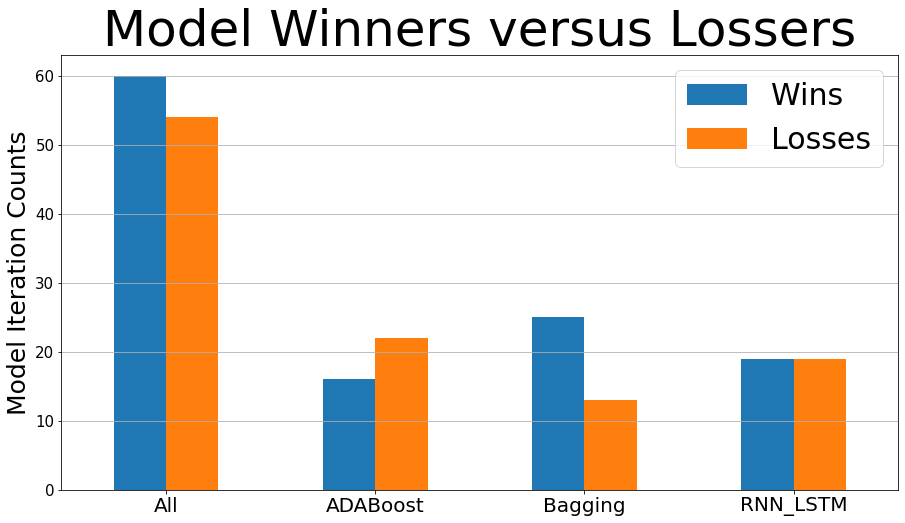

In [17]:
allModelResults[['Wins','Losses']].plot(kind='bar',figsize=(15,8))
plt.title('Model Winners versus Lossers', fontsize=50)
#plt.xlabel('Models')
plt.legend(loc=1, prop={'size':30})
plt.ylabel('Model Iteration Counts', fontsize=25)
plt.yticks(fontsize=15)
plt.grid(axis='y', which='major')
plt.xticks(range(len(allModelResults['Name'].values)),labels=allModelResults['Name'].values, rotation=0, fontsize=20);

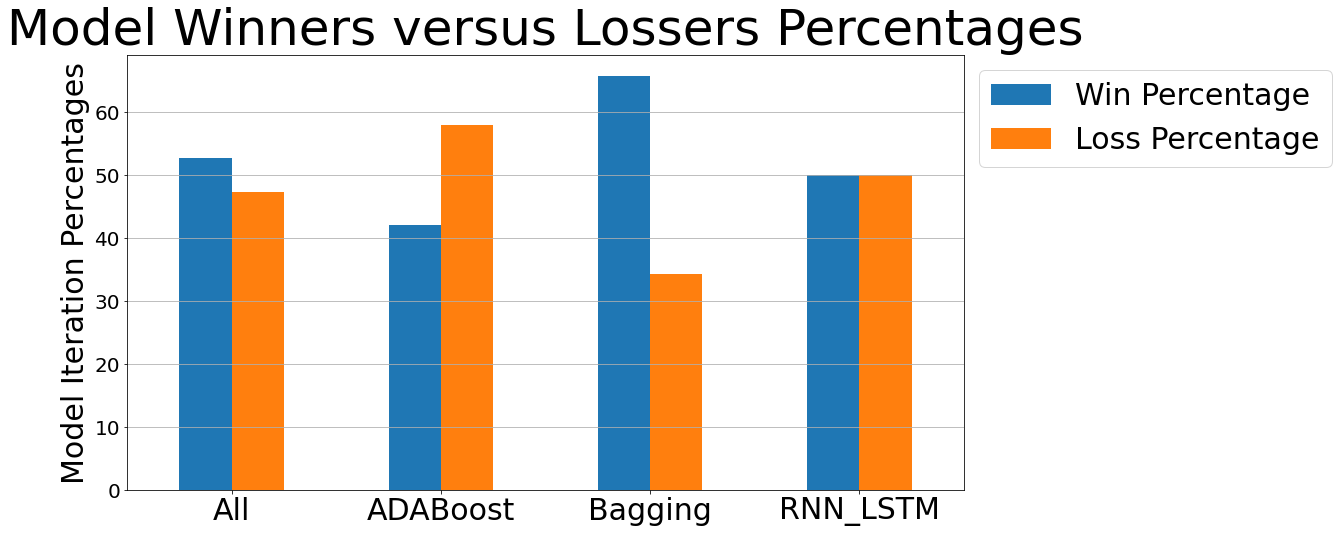

In [21]:
allModelResults[['Win Percentage','Loss Percentage']].plot(kind='bar',figsize=(15,8))
plt.title('Model Winners versus Lossers Percentages', fontsize=50)
#plt.xlabel('Models')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size':30})
plt.ylabel('Model Iteration Percentages', fontsize=30)
plt.grid(axis='y', which='major')
plt.xticks(range(len(allModelResults['Name'].values)),labels=allModelResults['Name'].values, rotation=0, fontsize=30)
yvals= ['0.00%','10%','20%','30%','40%','50%','60%']
plt.yticks(fontsize=20);

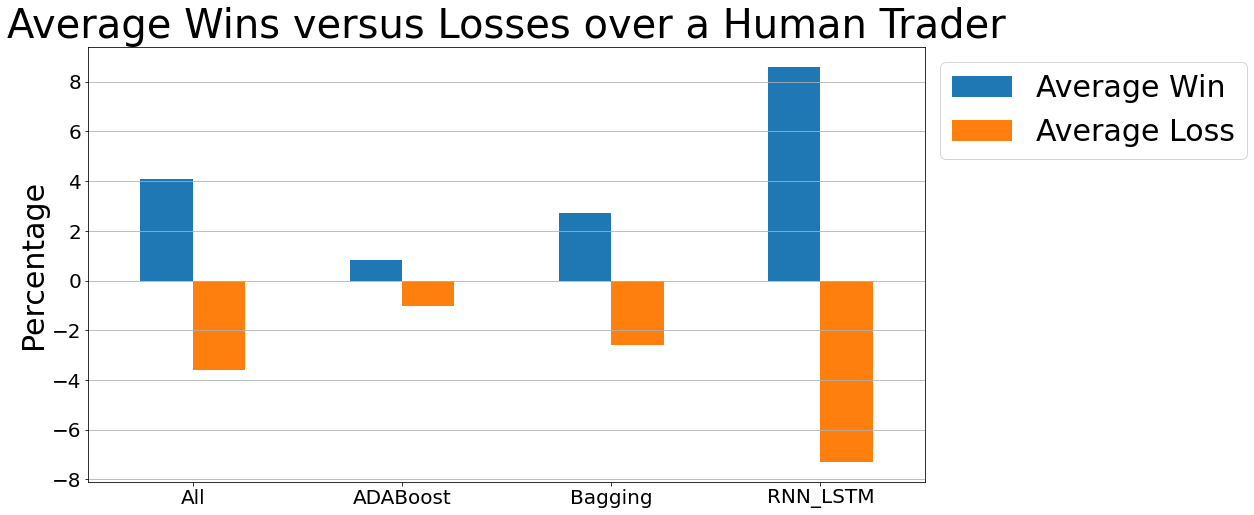

In [20]:
allModelResults[['Average Win','Average Loss']].plot(kind='bar',figsize=(15,8))
plt.title('Average Wins versus Losses over a Human Trader', fontsize=40)
plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size':30})
plt.ylabel('Percentage', fontsize=30)
plt.grid(axis='y', which='major')
plt.xticks(range(len(allModelResults['Name'].values)),labels=allModelResults['Name'].values, rotation=0, fontsize=20)
plt.yticks(fontsize=20);

Maybe look at this link using bokeh visualizations but I am good with the above plots.


https://towardsdatascience.com/interactive-bar-charts-with-bokeh-7230e5653ba3
